<a href="https://colab.research.google.com/github/ZEY0D/schiesser-antibody-modeling/blob/main/PINN_anti_body_binding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


Problem Parameters

In [ ]:
# Constants
D = 1e-3           # Diffusion coefficient
kf = 1.0           # Forward binding rate
kr = 0.1           # Reverse binding rate
cb_sat = 1.0       # Saturation concentration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


PINN Neural Network

In [ ]:
# Main PINN for c(z,t)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, z, t):
        return self.net(torch.cat([z, t], dim=1))

# Secondary network to learn c_b(t)
class CB_Model(nn.Module):
    def __init__(self):
        super(CB_Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, t):
        return self.net(t)


Create Training Points

In [ ]:
# Domain boundaries
z_min, z_max = 0.0, 1.0
t_min, t_max = 0.0, 1.0

# Collocation points
n_samples = 10000
z_colloc = torch.rand(n_samples, 1, device=device)
t_colloc = torch.rand(n_samples, 1, device=device)

# Initial condition: c(z,0) = 1
z_init = torch.linspace(z_min, z_max, 100).view(-1, 1).to(device)
t_init = torch.zeros_like(z_init).to(device)
c_init = torch.ones_like(z_init).to(device)

# Boundary conditions
t_bc = torch.linspace(t_min, t_max, 100).view(-1, 1).to(device)
z_bc_right = torch.ones_like(t_bc).to(device)
c_bc_right = torch.ones_like(t_bc).to(device)

z_bc_left = torch.zeros_like(t_bc).to(device)


Physics Loss Function (Diffusion PDE)

In [ ]:
def physics_loss(model, z, t):
    z.requires_grad_(True)
    t.requires_grad_(True)
    c = model(z, t)
    c_t = torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c), create_graph=True)[0]
    c_z = torch.autograd.grad(c, z, grad_outputs=torch.ones_like(c), create_graph=True)[0]
    c_zz = torch.autograd.grad(c_z, z, grad_outputs=torch.ones_like(c), create_graph=True)[0]
    return torch.mean((c_t - D * c_zz)**2)


Training Loop

In [ ]:
# Initialize models and optimizer
pinn_model = PINN().to(device)
cb_model = CB_Model().to(device)

optimizer = torch.optim.Adam(
    list(pinn_model.parameters()) + list(cb_model.parameters()),
    lr=1e-3
)

# Training loop
epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()

    # PDE physics loss
    loss_pde = physics_loss(pinn_model, z_colloc, t_colloc)

    # Initial condition
    c_pred_init = pinn_model(z_init, t_init)
    loss_init = torch.mean((c_pred_init - c_init)**2)

    # Dirichlet BC at z=1
    c_pred_bc = pinn_model(z_bc_right, t_bc)
    loss_bc_right = torch.mean((c_pred_bc - c_bc_right)**2)

    # Neumann BC at z=0
    z_bc_left.requires_grad = True
    t_bc.requires_grad = True
    c_pred_left = pinn_model(z_bc_left, t_bc)
    c_z_left = torch.autograd.grad(c_pred_left, z_bc_left, grad_outputs=torch.ones_like(c_pred_left), create_graph=True)[0]
    loss_bc_left = torch.mean(c_z_left**2)

    # Surface reaction at z=0
    c_pred_surface = pinn_model(z_bc_left, t_bc)
    cb_pred = cb_model(t_bc)
    c_z_surface = torch.autograd.grad(c_pred_surface, z_bc_left, grad_outputs=torch.ones_like(c_pred_surface), create_graph=True)[0]
    rhs = kf * c_pred_surface * (cb_sat - cb_pred) - kr * cb_pred
    loss_reaction = torch.mean((D * c_z_surface - rhs)**2)

    # Total loss
    loss = loss_pde + loss_init + loss_bc_right + loss_bc_left + loss_reaction
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4e}")


Epoch 0, Loss: 2.8466e+00
Epoch 200, Loss: 5.0789e-03
Epoch 400, Loss: 2.1126e-03
Epoch 600, Loss: 9.3097e-04
Epoch 800, Loss: 3.2915e-04
Epoch 1000, Loss: 1.5043e-04
Epoch 1200, Loss: 1.0892e-04
Epoch 1400, Loss: 7.7423e-05
Epoch 1600, Loss: 5.3084e-05
Epoch 1800, Loss: 3.4956e-05


Results visualization

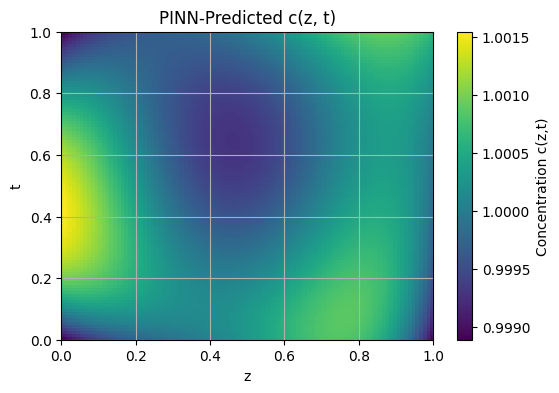

In [ ]:
# Evaluate c(z,t) from the model
z_test = torch.linspace(0, 1, 100)
t_test = torch.linspace(0, 1, 100)
Z, T = torch.meshgrid(z_test, t_test, indexing='ij')
z_flat = Z.reshape(-1, 1).to(device)
t_flat = T.reshape(-1, 1).to(device)

with torch.no_grad():
    c_pred = pinn_model(z_flat, t_flat).cpu().numpy()

C = c_pred.reshape(100, 100)

plt.figure(figsize=(6, 4))
plt.imshow(C.T, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Concentration c(z,t)')
plt.xlabel('z')
plt.ylabel('t')
plt.title('PINN-Predicted c(z, t)')
plt.grid(True)
plt.show()


Plot the Surface Binding Cb(t)

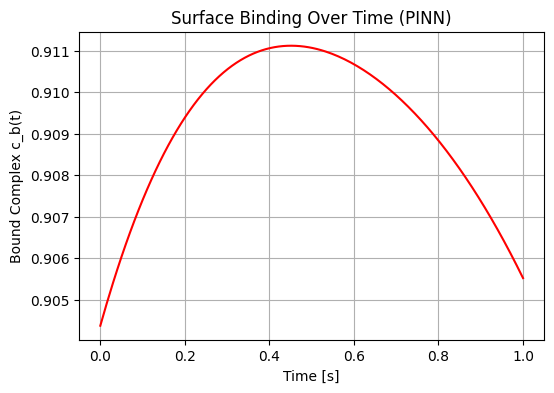

In [ ]:
# Plot the surface-bound complex over time
with torch.no_grad():
    t_plot = torch.linspace(0, 1, 200).view(-1, 1).to(device)
    cb_vals = cb_model(t_plot).cpu().numpy()

plt.figure(figsize=(6, 4))
plt.plot(t_plot.cpu().numpy(), cb_vals, color='red')
plt.xlabel('Time [s]')
plt.ylabel('Bound Complex c_b(t)')
plt.title('Surface Binding Over Time (PINN)')
plt.grid(True)
plt.show()
